# Image Colorization (PyTorch)

This notebook is a PyTorch rewrite of the original TensorFlow/Keras version. It keeps the same overall approach: **grayscale input → RGB output** with a small fully-convolutional CNN, trained with **MSE**.


In [1]:
import os, glob, random, math
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# ---- config ----
width = 128
height = 128
IMG_SIZE = (width, height)   # (W, H) for PIL resize
BATCH_SIZE = 32
NUM_WORKERS = 0  # set >0 if your environment supports multiprocessing
SEED = 42

# Point this to your folder that contains images (jpg/jpeg/png)
DATA_DIR = "./img_align_celeba"  # <-- change this

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# ---- list image files ----
patterns = ["*.jpg", "*.jpeg", "*.png"]
files = []
for pat in patterns:
    files.extend(glob.glob(str(Path(DATA_DIR) / pat)))

if len(files) == 0:
    raise ValueError(f"No images found in: {DATA_DIR}")

print("Total images found:", len(files))


Total images found: 202599


In [ ]:
# Optional: downsample the dataset for quick experiments
# MAX_IMAGES = 20000
# random.seed(SEED)
# random.shuffle(files)
# files = files[:MAX_IMAGES]
# print("Using images:", len(files))


In [3]:
# ---- split into train/val/test ----
random.seed(SEED)
random.shuffle(files)

n_total = len(files)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)

train_files = files[:n_train]
val_files   = files[n_train:n_train + n_val]
test_files  = files[n_train + n_val:]

print("Train:", len(train_files), "Val:", len(val_files), "Test:", len(test_files))


Train: 162079 Val: 20259 Test: 20261


In [4]:
class ColorizationDataset(Dataset):
    def __init__(self, file_list, img_size=(128,128)):
        self.file_list = list(file_list)
        self.img_size = img_size  # (W, H)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        # Load RGB
        img = Image.open(path).convert("RGB")
        img = img.resize(self.img_size, resample=Image.BILINEAR)

        # RGB target in [0,1], shape (3,H,W)
        y = np.asarray(img, dtype=np.float32) / 255.0
        y = np.transpose(y, (2, 0, 1))
        y = torch.from_numpy(y)

        # Grayscale input in [0,1], shape (1,H,W)
        gray = img.convert("L")
        x = np.asarray(gray, dtype=np.float32) / 255.0
        x = torch.from_numpy(x).unsqueeze(0)

        return x, y

train_ds = ColorizationDataset(train_files, IMG_SIZE)
val_ds   = ColorizationDataset(val_files, IMG_SIZE)
test_ds  = ColorizationDataset(test_files, IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))

# free file lists you don't need
del files


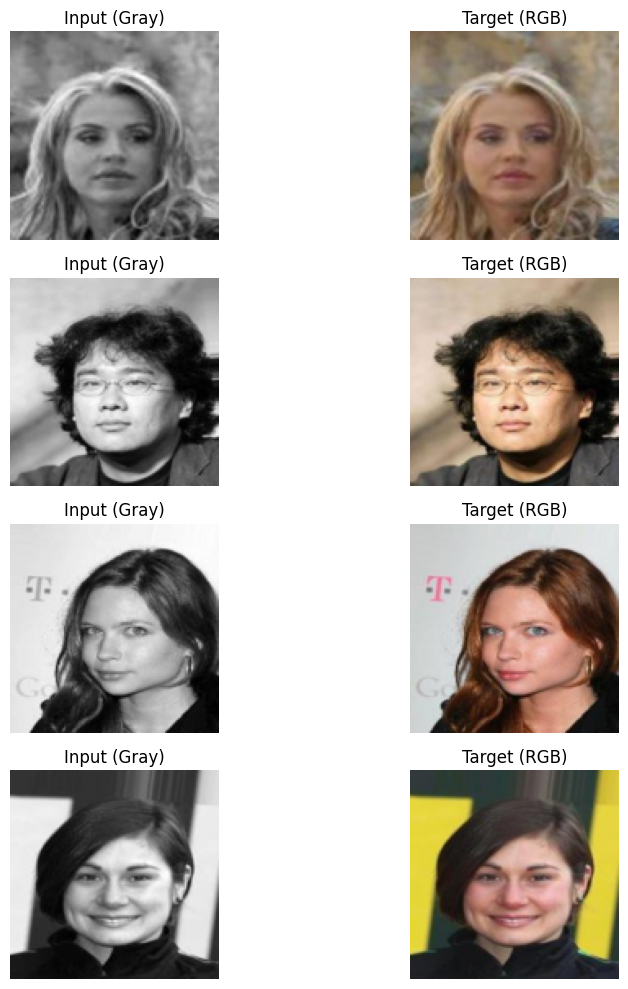

In [5]:
# Quick sanity-check: visualize a few (gray, rgb) pairs
def show_samples(ds, n=4):
    n = min(n, len(ds))
    plt.figure(figsize=(10, 2.5*n))
    for i in range(n):
        x, y = ds[i]
        x_img = x.squeeze(0).numpy()
        y_img = np.transpose(y.numpy(), (1,2,0))
        plt.subplot(n, 2, 2*i+1); plt.imshow(x_img, cmap="gray"); plt.title("Input (Gray)"); plt.axis("off")
        plt.subplot(n, 2, 2*i+2); plt.imshow(y_img); plt.title("Target (RGB)"); plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_ds, n=4)


In [6]:
# ---- model (same spirit as original Keras Sequential) ----
class SimpleColorizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),  # outputs in [0,1]
        )

    def forward(self, x):
        return self.net(x)

model = SimpleColorizer().to(device)
print(model)


SimpleColorizer(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
  )
)


In [8]:
# ---- metrics ----
def mae_metric(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred)).item()

def psnr_metric(y_true, y_pred, eps=1e-8):
    mse = torch.mean((y_true - y_pred) ** 2).item()
    return 10.0 * math.log10(1.0 / (mse + eps))

# SSIM via skimage (CPU; slower but simple and dependency-light)
from skimage.metrics import structural_similarity as ssim

def ssim_metric_batch(y_true, y_pred):
    # y_true/y_pred: (B,3,H,W) in [0,1]
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    B = y_true_np.shape[0]
    scores = []
    for i in range(B):
        a = np.transpose(y_true_np[i], (1,2,0))
        b = np.transpose(y_pred_np[i], (1,2,0))
        scores.append(ssim(a, b, channel_axis=2, data_range=1.0))
    return float(np.mean(scores))


In [9]:
# ---- training setup ----
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10

history = {
    "loss": [],
    "val_loss": [],
    "mae": [],
    "val_mae": [],
    "psnr": [],
    "val_psnr": [],
    "ssim": [],
    "val_ssim": [],
}


In [10]:
def run_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_mae = 0.0
    total_psnr = 0.0
    # SSIM is expensive; compute on a limited number of batches
    ssim_scores = []
    max_ssim_batches = 5

    n_batches = 0

    for batch_idx, (x, y) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.set_grad_enabled(train):
            y_hat = model(x)
            loss = criterion(y_hat, y)

            if train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        total_mae  += mae_metric(y, y_hat)
        total_psnr += psnr_metric(y, y_hat)

        if batch_idx < max_ssim_batches:
            ssim_scores.append(ssim_metric_batch(y, y_hat))

        n_batches += 1

    avg_loss = total_loss / max(n_batches, 1)
    avg_mae  = total_mae  / max(n_batches, 1)
    avg_psnr = total_psnr / max(n_batches, 1)
    avg_ssim = float(np.mean(ssim_scores)) if ssim_scores else float("nan")

    return avg_loss, avg_mae, avg_psnr, avg_ssim


for epoch in range(1, EPOCHS + 1):
    train_loss, train_mae, train_psnr, train_ssim = run_epoch(model, train_loader, train=True)
    val_loss, val_mae, val_psnr, val_ssim = run_epoch(model, val_loader, train=False)

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["mae"].append(train_mae)
    history["val_mae"].append(val_mae)
    history["psnr"].append(train_psnr)
    history["val_psnr"].append(val_psnr)
    history["ssim"].append(train_ssim)
    history["val_ssim"].append(val_ssim)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"loss {train_loss:.4f} val {val_loss:.4f} | "
        f"mae {train_mae:.4f} val {val_mae:.4f} | "
        f"psnr {train_psnr:.2f} val {val_psnr:.2f} | "
        f"ssim {train_ssim:.3f} val {val_ssim:.3f}"
    )


Epoch 01/10 | loss 0.0053 val 0.0049 | mae 0.0458 val 0.0425 | psnr 22.95 val 23.23 | ssim 0.303 val 0.924
Epoch 02/10 | loss 0.0047 val 0.0048 | mae 0.0418 val 0.0426 | psnr 23.38 val 23.30 | ssim 0.922 val 0.930
Epoch 03/10 | loss 0.0046 val 0.0047 | mae 0.0409 val 0.0412 | psnr 23.49 val 23.39 | ssim 0.935 val 0.931
Epoch 04/10 | loss 0.0046 val 0.0046 | mae 0.0404 val 0.0403 | psnr 23.54 val 23.50 | ssim 0.931 val 0.930
Epoch 05/10 | loss 0.0045 val 0.0047 | mae 0.0402 val 0.0410 | psnr 23.57 val 23.43 | ssim 0.930 val 0.931
Epoch 06/10 | loss 0.0045 val 0.0046 | mae 0.0400 val 0.0403 | psnr 23.60 val 23.50 | ssim 0.927 val 0.935
Epoch 07/10 | loss 0.0045 val 0.0045 | mae 0.0398 val 0.0399 | psnr 23.61 val 23.55 | ssim 0.930 val 0.934
Epoch 08/10 | loss 0.0045 val 0.0045 | mae 0.0397 val 0.0397 | psnr 23.64 val 23.56 | ssim 0.935 val 0.933
Epoch 09/10 | loss 0.0045 val 0.0045 | mae 0.0396 val 0.0396 | psnr 23.64 val 23.56 | ssim 0.931 val 0.934
Epoch 10/10 | loss 0.0044 val 0.0045 

In [11]:
# ---- Evaluate on test set ----
test_loss, test_mae, test_psnr, test_ssim = run_epoch(model, test_loader, train=False)
print(f"TEST | loss {test_loss:.4f} | mae {test_mae:.4f} | psnr {test_psnr:.2f} | ssim {test_ssim:.3f}")


TEST | loss 0.0044 | mae 0.0395 | psnr 23.69 | ssim 0.933


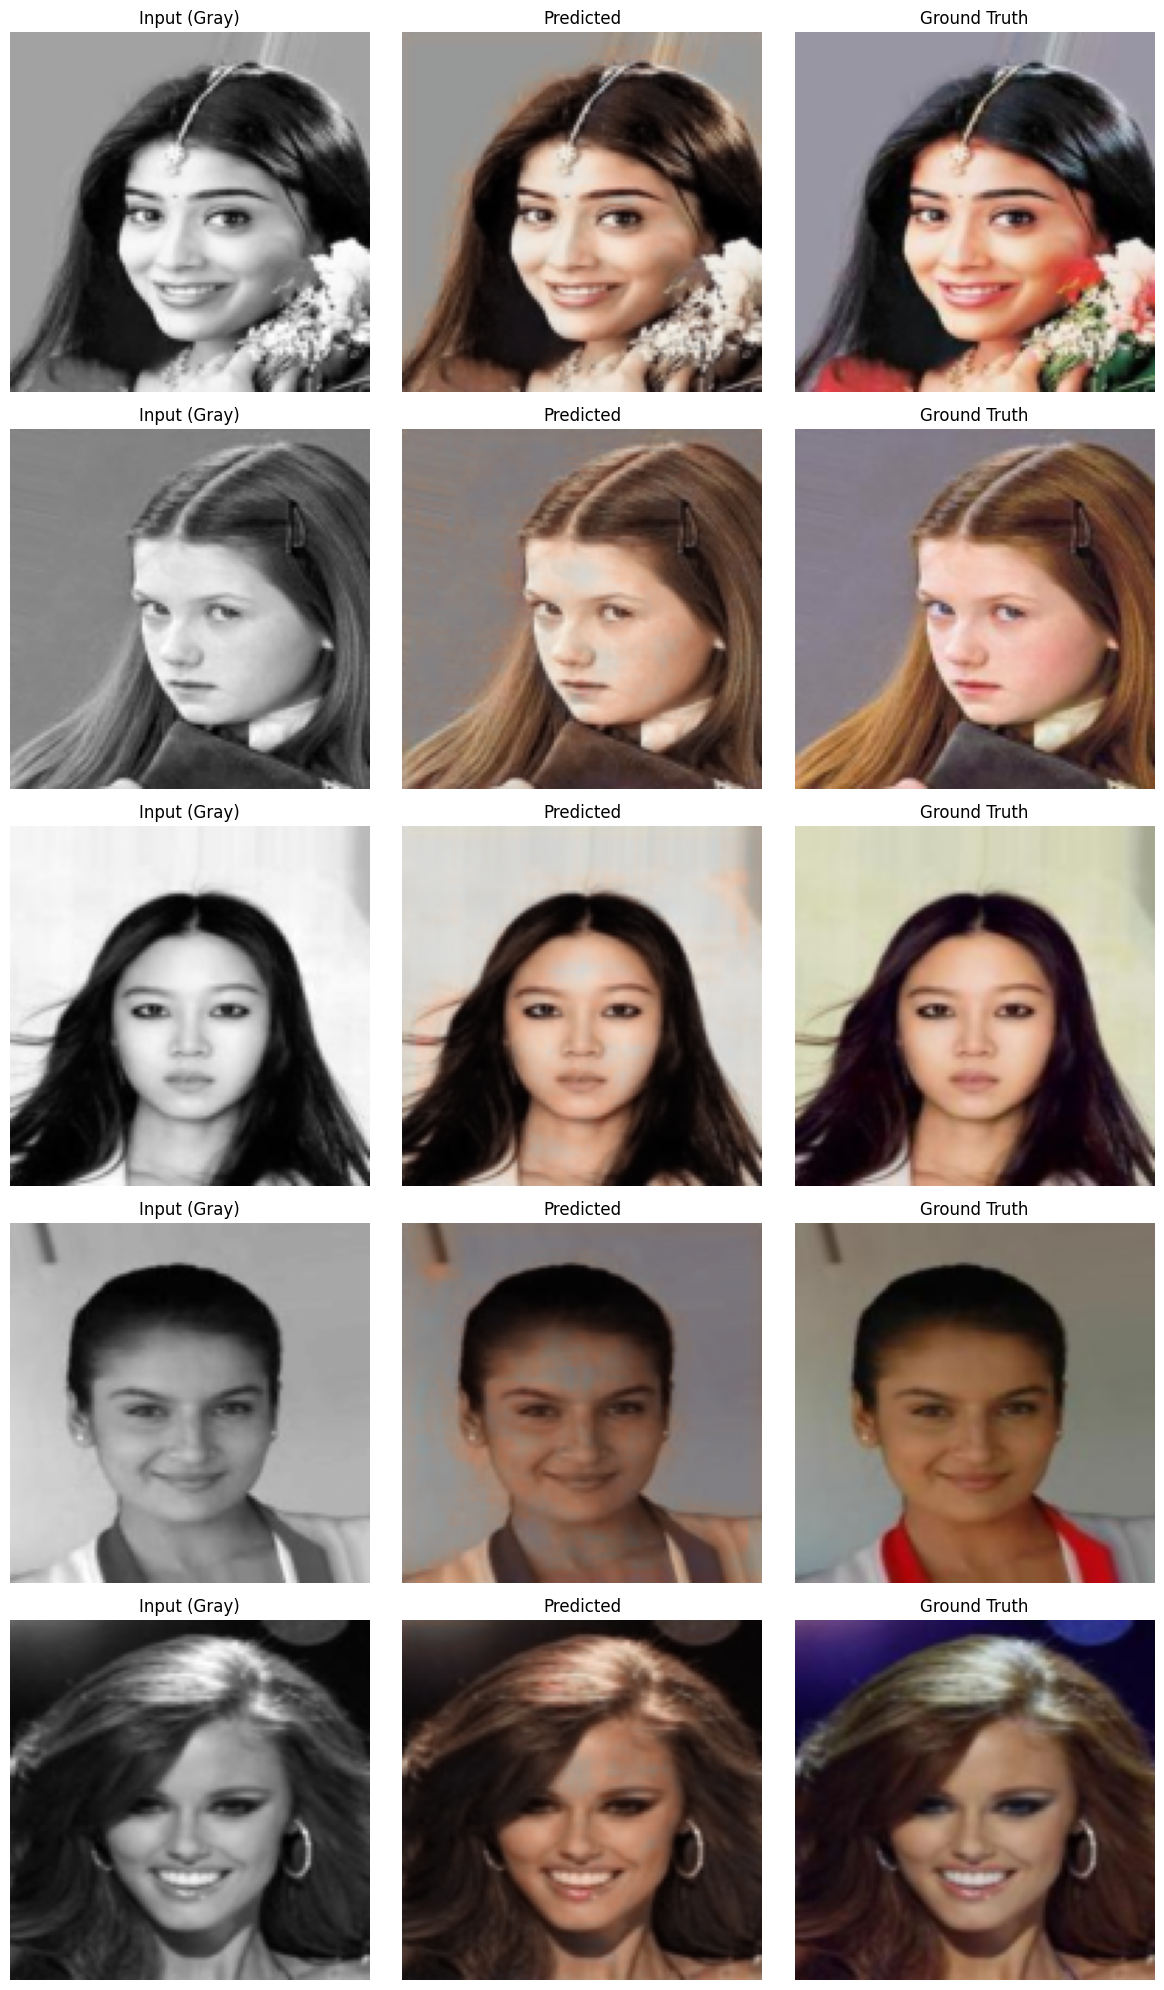

In [12]:
# ---- Visualize predictions on a few test images ----
def tensor_to_img(t):
    # t: (C,H,W) in [0,1] -> (H,W,C)
    t = t.detach().cpu().numpy()
    return np.transpose(t, (1,2,0))

sample_paths = random.sample(test_files, k=min(5, len(test_files)))
sample_ds = ColorizationDataset(sample_paths, IMG_SIZE)

model.eval()
plt.figure(figsize=(12, 4*len(sample_ds)))

for i in range(len(sample_ds)):
    x, y = sample_ds[i]
    with torch.no_grad():
        pred = model(x.unsqueeze(0).to(device)).squeeze(0)

    x_img = x.squeeze(0).numpy()
    pred_img = tensor_to_img(pred).clip(0,1)
    y_img = tensor_to_img(y).clip(0,1)

    plt.subplot(len(sample_ds), 3, i*3 + 1); plt.imshow(x_img, cmap="gray"); plt.title("Input (Gray)"); plt.axis("off")
    plt.subplot(len(sample_ds), 3, i*3 + 2); plt.imshow(pred_img); plt.title("Predicted"); plt.axis("off")
    plt.subplot(len(sample_ds), 3, i*3 + 3); plt.imshow(y_img); plt.title("Ground Truth"); plt.axis("off")

plt.tight_layout()
plt.show()


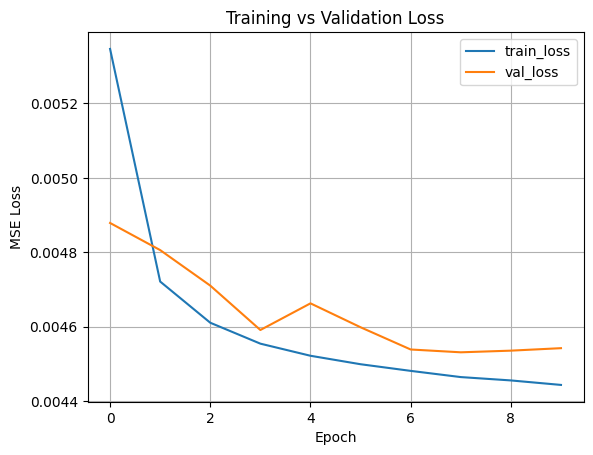

In [13]:
# ---- Plot training curves ----
plt.figure()
plt.plot(history["loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
